### Importing libraries ###

In [1]:
import torchtext
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,random_split
import re
from argparse import Namespace
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import sentencepiece as spm
import re
import torchtext.vocab as tv
from torchtext.vocab import GloVe;
import numpy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
import nltk
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


In [2]:

nltk.download('stopwords')
nltk.download('punkt_tab')

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charlessanthakumar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/charlessanthakumar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/charlessanthakumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/charlessanthakumar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/charlessanthakumar/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:

global_vectors = GloVe(name='6B', dim=300);

In [4]:

args = Namespace(
data_directory = "../data/balanced_dataset.csv",
seed = 1300,
max_sentence_length = 100,
lower = True,
start_token = "<sos>",
end_token = "<eos>",
unk_token = "<unk>",
pad_token = "<pad>",
vocab_size = 0,
embedding_dim = 300,
device = "cuda" if torch.cuda.is_available() else "cpu",
);

## DATA preprocessing ##
Done by Cynthia, Houmam, Abderraouf

In [5]:
toxic_frame = pd.read_csv(args.data_directory);
toxic_frame = toxic_frame.dropna()

toxic_frame

,id,comment_text,target
0,5283379,actually its a pretty important symbol of our ...,0.0
1,5775176,trump and truth are not good friends this man...,1.0
2,6012321,so must trump given how many rats have been fi...,1.0
3,6210499,harris scored 2pts in 34 minutes pathetic harr...,1.0
4,219580848446a719,try harder plz lolz a spam filter hahaha the...,1.0
...,...,...,...
9995,6085768,what this group of liberals accomplished was t...,0.0
9996,325286,start making cash right now get more time with...,0.0
9997,5180458,firstly this much ballyhooed compliance annou...,0.0
9998,6a28b78723c1c6f2,you are so fucking dummm man i just dnt get it...,1.0


In [6]:
toxic_frame.isnull().sum()

id              0
comment_text    0
target          0
dtype: int64

In [7]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
toxic_frame['comment_text']= toxic_frame['comment_text'].apply(lambda x:expand_contractions(x));

In [8]:

toxic_frame['comment_text'] = toxic_frame['comment_text'].apply(
    lambda x: re.sub(r'\w*\d\w*', '', x)
)
toxic_frame['comment_text']=toxic_frame['comment_text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
# Removing extra spaces
toxic_frame['comment_text']= toxic_frame['comment_text'].apply(lambda x: re.sub(' +',' ',x))
#turning all to lower case
toxic_frame['comment_text']= toxic_frame['comment_text'].apply(lambda x: x.lower())
for index,text in enumerate(toxic_frame['comment_text'][35:40]):
  print('Review %d:\n'%(index+1),text)

Review 1:
 and gas bag and liar
Review 2:
 this ip has again been temporarily blocked for reason of vandalism if you will write and edit responsibly in the future you may contribute here after the block expires continued vandalism can result in a longer term block mar coordinated universal time
Review 3:
 enjoy it while it lasts the islamification of canada has begun
Review 4:
 the people of alaska deserve less money for programs and services that benefit them rep mike hawker apparently what an idiot
Review 5:
 nixon was just going to keep firing people until he got what many scholars believe he had the legal right to do legal and moral being distinct issues here why gut the doj with another dozen firings and leave things in disarray bork appointed the subsequent prosecutor who drove nixon out of office


In [9]:
#removing stop words
stop_words = set(stopwords.words('english'))
toxic_frame['comment_text']= toxic_frame['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [10]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized)

# Apply to the column
toxic_frame['comment_text'] = toxic_frame['comment_text'].apply(lemmatize_text);


In [11]:
toxic_frame = toxic_frame.dropna()

toxic_frame['comment_text'] = toxic_frame['comment_text'].astype('string')


In [12]:
toxic_frame.isnull().sum()

id              0
comment_text    0
target          0
dtype: int64

In [13]:
toxic_frame['comment_text'].dtype


string[python]

In [14]:
train_set_len = int(len(toxic_frame)*0.80);

test_set_len = int(len(toxic_frame)*0.10);

val_set_len = int(len(toxic_frame)*0.10);

toxic_frame.loc[:train_set_len,'split'] = "train";

toxic_frame.loc[train_set_len:train_set_len + test_set_len,'split'] = "test";

toxic_frame.loc[train_set_len + test_set_len:,'split'] = "val";

toxic_frame.to_csv(f"../data/data_split.csv");

args.data_split = "../data/data_split.csv";

In [15]:
def pad_sequence(tokenizer,encoded_ids, max_length, pad_id = args.pad_token):
    
    # Truncate if too long
    if len(encoded_ids) > max_length:
        encoded_ids = encoded_ids[:max_length]
    
    # Add padding
    padding = [pad_id] * (max_length - len(encoded_ids))
    return encoded_ids + padding;

In [16]:
class Vectorizer():
    
    def __init__(self,tokenizer,vocabulary):
        self.tokenizer = tokenizer;
        self.vocabulary = vocabulary;
        pass;
    
    @classmethod
    def from_dataframe(cls, csvFile,columns):
        """
        Instantiate the vectorizer from the dataset dataframe
        
        Args:

        dataFrame (pandas.DataFrame): Dataset 
        xColumnName : name of features column.

        Returns: an instance of the Vectorizer

        """

        datafile = pd.read_csv(csvFile);

        tokens_iterator = [];

        tokenizer = torchtext.data.utils.get_tokenizer("basic_english");
        
        for i,row in datafile[[columns[0]]].iterrows():
            text = row[columns[0]];
            # print(type(text));
            text = str(text)
            tokens = tokenizer(text);
            tokens_iterator.append(tokens);

        caption_vocab = tv.build_vocab_from_iterator(tokens_iterator,min_freq = 3,specials=[args.pad_token, args.unk_token, args.start_token , args.end_token]);
        
        caption_vocab.set_default_index(caption_vocab[args.unk_token]);
   
        return cls(tokenizer,caption_vocab);
    
    
    
    def vectorize(self,sentence , max_length , add_special = False):
        
        """
        Create a numerical vector for the sentence
        
        Args:
        tokenizer: sentencepiece tokenizer.
        sentence (str): the sentence
        add_special (boolean) : Adding special tokens (<sos>,<eos>).
        
        Returns:
        Tokens indices vector.
        
        """
        vector = self.tokenizer(sentence);
        vector = pad_sequence(self.tokenizer,vector, max_length);
        ids = [];
        for i,token in enumerate(vector):
            ids.append(self.vocabulary[token]);
        
        return ids;


In [17]:
class CustomDataSet(Dataset):
    
    def __init__(self,datafile,vectorizer):
        
        dataFrame = pd.read_csv(datafile);
        
        self._dataFrame = dataFrame;
        self._vectorizer = vectorizer;
        
        self.train_df = self._dataFrame[self._dataFrame.split == "train"];
        self.train_size = len(self.train_df);
        
        self.val_df = self._dataFrame[self._dataFrame.split == "val"];
        self.val_size = len(self.val_df);
        
        self.test_df = self._dataFrame[self._dataFrame.split == "test"];
        self.test_size = len(self.test_df);

        self._lookup_dict = {'train': (self.train_df, self.train_size),
        'val': (self.val_df, self.val_size),
        'test': (self.test_df, self.test_size)};
        
        self.set_split();  # setting train as default data set.

    
    @classmethod
    def load_dataset_and_make_vectorizer(cls,datafile):
        datafile = datafile;
        return cls(datafile, Vectorizer.from_dataframe(datafile,['comment_text']));

    
    def get_vectorizer(self):
        return self._vectorizer;
    
    
    def set_split(self, split="train"):
        
        """ selects the splits in the dataset using a column in the dataframe
        Args:finaldata.csv
        split (str): one of "train", "val", or "test"
        """
        self._target_split = split;

        self._target_df, self._target_size = self._lookup_dict[split];


    def __getitem__(self, index):
        row = self._target_df.iloc[index]
    
        text = row['comment_text']
        if not isinstance(text, str):
            text = str(text)          #String conversion to handle the float values

        source = self._vectorizer.vectorize(text, args.max_sentence_length)
        target = row['target']

        return torch.tensor(source), torch.tensor(target)

    
    def __len__(self):
        return self._target_size;


    

In [18]:

dataset = CustomDataSet.load_dataset_and_make_vectorizer(args.data_split)


train_dataset = CustomDataSet(args.data_split, dataset.get_vectorizer())
train_dataset.set_split("train")

val_dataset = CustomDataSet(args.data_split, dataset.get_vectorizer())
val_dataset.set_split("val")

# increased batch_size to 128

dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)


In [19]:
toxic_frame['comment_text'].dtype


string[python]

In [20]:
for x,y in dataloader:
    break;
print(x,y)

tensor([[1120,    5,   25,  ...,    0,    0,    0],
        [  39,    5,   48,  ...,    0,    0,    0],
        [ 212,    1,  847,  ...,    0,    0,    0],
        ...,
        [ 387,  342, 1667,  ...,    0,    0,    0],
        [2228, 8034,    8,  ...,    0,    0,    0],
        [1417, 6381, 1421,  ...,    0,    0,    0]]) tensor([1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
        1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 0.], dtype=torch.float64)


In [21]:

def prepare_embedding_matrix(dataset_words, pre_embeddings):
    word_to_idx = pre_embeddings.stoi
    embedding_matrix = pre_embeddings.vectors
    embedding_dim = embedding_matrix.shape[1]

    final_embeddings = torch.zeros((len(dataset_words), embedding_dim))

    for i, word in enumerate(dataset_words):
        if word in word_to_idx and word_to_idx[word] < embedding_matrix.shape[0]:
            final_embeddings[i] = embedding_matrix[word_to_idx[word]]
        else:
            embedding_i = torch.empty(embedding_dim)
            torch.nn.init.xavier_uniform_(embedding_i.unsqueeze(0))
            final_embeddings[i] = embedding_i

    embedding_layer = nn.Embedding(
        num_embeddings=len(dataset_words),
        embedding_dim=embedding_dim
    )
    embedding_layer.weight.data = final_embeddings

    return embedding_layer


In [22]:
embedding_layer = prepare_embedding_matrix(list(dataset.get_vectorizer().vocabulary.get_stoi().keys()),global_vectors);

### Model implementation - Light-weight DNN

In [23]:
class LightDNN(nn.Module):
    def __init__(self, embedding_layer, embedding_dim, hidden_dim=256, output_dim=1, dropout=0.3):
        super(LightDNN, self).__init__()

        self.embedding = embedding_layer
        self.embedding.weight.requires_grad = False  # keep GloVe frozen

        self.block1 = nn.Sequential(
            nn.Linear(embedding_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.block2 = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.output = nn.Linear(128, output_dim)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)  # (B, T, D)
        pooled = torch.cat([
            embedded.mean(dim=1),
            embedded.max(dim=1).values
        ], dim=1)  # (B, 2D)

        x = self.block1(pooled)
        x = self.block2(x)
        return self.output(x).squeeze(1)  # logits (no sigmoid)


In [24]:

embedding_dim = embedding_layer.embedding_dim 
model = LightDNN(embedding_layer, embedding_dim=embedding_dim).to(args.device)

In [25]:

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=9e-5,            # Unified learning rate
    weight_decay=5e-4   # L2 regularization
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    patience=3, 
    factor=0.5,
    verbose=True,
    min_lr=5e-7
)



Epoch 1 | Train Loss: 0.7044 | Val Loss: 0.6897 | Val Acc: 0.5164
Epoch 2 | Train Loss: 0.6973 | Val Loss: 0.6873 | Val Acc: 0.5639
Epoch 3 | Train Loss: 0.6949 | Val Loss: 0.6870 | Val Acc: 0.5500
No improvement. Early stop counter: 1/8
Epoch 4 | Train Loss: 0.6921 | Val Loss: 0.6895 | Val Acc: 0.5223
Epoch 5 | Train Loss: 0.6885 | Val Loss: 0.6825 | Val Acc: 0.5758
Epoch 6 | Train Loss: 0.6889 | Val Loss: 0.6797 | Val Acc: 0.5877
Unfroze embedding layer
Epoch 7 | Train Loss: 0.6876 | Val Loss: 0.6793 | Val Acc: 0.5619
Epoch 8 | Train Loss: 0.6821 | Val Loss: 0.6692 | Val Acc: 0.5996
No improvement. Early stop counter: 1/8
Epoch 9 | Train Loss: 0.6802 | Val Loss: 0.6692 | Val Acc: 0.5828
Epoch 10 | Train Loss: 0.6709 | Val Loss: 0.6652 | Val Acc: 0.5847
No improvement. Early stop counter: 1/8
Epoch 11 | Train Loss: 0.6606 | Val Loss: 0.6680 | Val Acc: 0.5808
Epoch 12 | Train Loss: 0.6509 | Val Loss: 0.6321 | Val Acc: 0.6482
Epoch 13 | Train Loss: 0.6378 | Val Loss: 0.6219 | Val Acc: 0

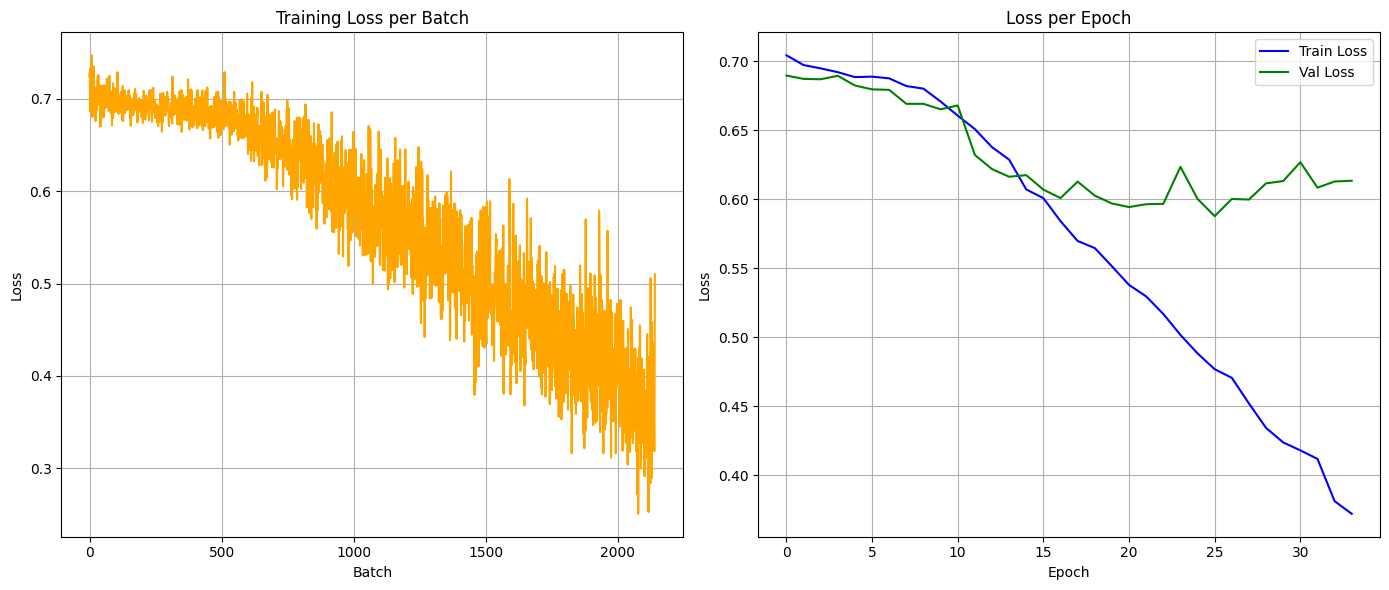

In [26]:
EPOCHS = 100
patience = 8
trigger_times = 0
best_val_acc = 0.0
train_loss_per_batch = []
train_loss_per_epoch = []
val_loss_per_epoch = []
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    if epoch == 6:
        model.embedding.weight.requires_grad = True
        print("Unfroze embedding layer")

    model.train()
    total_train_loss = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(args.device), targets.to(args.device).float()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_loss_per_batch.append(loss.item())  # <-- log batch loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item() * inputs.size(0)


    avg_train_loss = total_train_loss / len(dataloader.dataset)
    train_loss_per_epoch.append(avg_train_loss)

    # ----------- VALIDATION ----------- #

    model.eval()
    total_val_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(args.device), val_targets.to(args.device).float()
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            total_val_loss += val_loss.item() * val_inputs.size(0)

            preds = torch.round(torch.sigmoid(val_outputs))
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(val_targets.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    val_acc = accuracy_score(all_labels, all_preds)
    val_loss_per_epoch.append(avg_val_loss)

    # ----------- EARLY STOPPING LOGIC ----------- #
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        #print(f"✔️ New best model at Epoch {epoch+1}")
        torch.save(model.state_dict(), 'best_version_v2.pth')
    else:
        trigger_times += 1
        print(f"No improvement. Early stop counter: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1:01d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")



# Plot training loss per batch
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_per_batch, color='orange')
plt.title('Training Loss per Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)

# Plot train/val loss per epoch
plt.subplot(1, 2, 2)
plt.plot(train_loss_per_epoch, label='Train Loss', color='blue')
plt.plot(val_loss_per_epoch, label='Val Loss', color='green')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [27]:
dataset.set_split("test")
model.load_state_dict(torch.load('best_version_v2.pth'))
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in DataLoader(dataset, batch_size=32):
        inputs = inputs.to(args.device)
        targets = targets.to(args.device).float()

        outputs = model(inputs)
        preds = (outputs > 0.5).float()

        all_preds.extend(preds.cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

# Compute metrics
acc = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)

print(f"Test Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


Test Accuracy: 0.6957, Precision: 0.7573, Recall: 0.5714, F1 Score: 0.6514
